# Data Science - ICARO
_________________________________
Clase: 13
Tema: Proyecto integrador - Supervisado
_________________________________


## Objetivo:
- Aplicar un flujo de trabajo de Machine Learning de principio a fin para resolver un problema de clasificación y uno de regresión, utilizando el dataset "Wine Quality".

---

## Índice

1. [Imports y Configuración Inicial](#imports)
2. [Carga y Preparación de Datos](#carga)
3. [Análisis Exploratorio de Datos (EDA)](#eda)
4. [**Tarea 1: Clasificación (Predecir Tipo de Vino)**](#clasificacion)
    - 4.1. [Preparación de Datos para Clasificación](#prep_clasificacion)
    - 4.2. [Modelos Base de Clasificación](#modelos_base_clasificacion)
    - 4.3. [**(A COMPLETAR) Modelos Avanzados y Optimización**](#completar_clasificacion)
    - 4.4. [**(A COMPLETAR) Tabla de Resultados y Conclusión de Clasificación**](#conclusion_clasificacion)
5. [**Tarea 2: Regresión (Predecir Calidad del Vino)**](#regresion)
    - 5.1. [Preparación de Datos para Regresión](#prep_regresion)
    - 5.2. [Modelo Base de Regresión](#modelo_base_regresion)
    - 5.3. [**(A COMPLETAR) Modelos Avanzados y Optimización**](#completar_regresion)
    - 5.4. [**(A COMPLETAR) Tabla de Resultados y Conclusión de Regresión**](#conclusion_regresion)
6. [**(A COMPLETAR) Conclusiones Finales del Proyecto**](#final)

---


<a name="imports"></a>
## 1. Imports y Configuración Inicial
En esta primera celda, importaremos todas las librerías que necesitaremos para nuestro análisis.

In [233]:
from time import time

In [234]:
# Manipulación de datos
import pandas as pd
import numpy as np

In [235]:
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [236]:
# Modelos y Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [237]:
# Métricas de evaluación
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score)

In [238]:
def highlight_best(row, row_index):
    if row.name == row_index:
        return ['background-color: lightgreen']*len(row)
    else:
        return ['']*len(row)

<a name="carga"></a>
## 2. Carga y Preparación de Datos
Vamos a cargar los dos datasets (vino tinto y vino blanco), añadiremos una columna para identificar el tipo de vino y luego los uniremos en un único DataFrame.

In [239]:
# URLs de los datasets
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Carga de los dataframes
df_red = pd.read_csv(url_red, sep=';')
df_white = pd.read_csv(url_white, sep=';')

In [240]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [241]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [242]:
# Creación de la columna 'type'
df_red['type'] = 'red'
df_white['type'] = 'white'

In [243]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [244]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [245]:
pd.concat([df_red, df_white], axis=0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [246]:
# Unión de los dataframes
df = pd.concat([df_red, df_white], axis=0)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [247]:
df_white.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


In [248]:
# Reseteamos el índice
df.reset_index(drop=True, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [249]:
print("Forma del dataset combinado:", df.shape)
print("\nPrimeras 5 filas:")
display(df.head())

Forma del dataset combinado: (6497, 13)

Primeras 5 filas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


<a name="eda"></a>
## 3. Análisis Exploratorio de Datos (EDA)
Es fundamental entender nuestros datos antes de modelar. Realizaremos un análisis descriptivo y algunas visualizaciones clave.

In [250]:
# Información general y chequeo de nulos
print("Información del DataFrame:")
df.info()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [251]:
print("\nEstadísticas Descriptivas:")
display(df.describe())


Estadísticas Descriptivas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [252]:
df_white.shape

(4898, 13)

In [253]:
df_red.shape

(1599, 13)

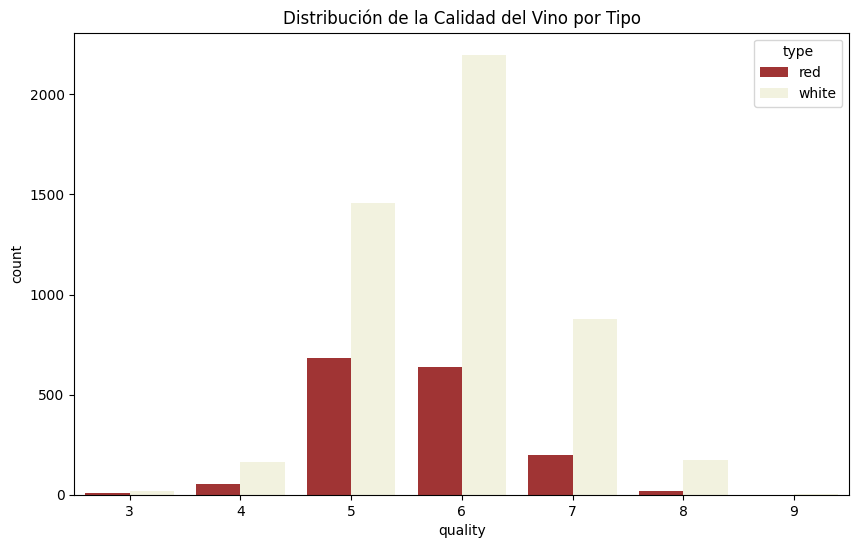

In [254]:
# Distribución de la variable 'quality' por tipo de vino
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='quality', hue='type', palette={'red': '#B22222', 'white': '#F5F5DC'})
plt.title('Distribución de la Calidad del Vino por Tipo')
plt.show()

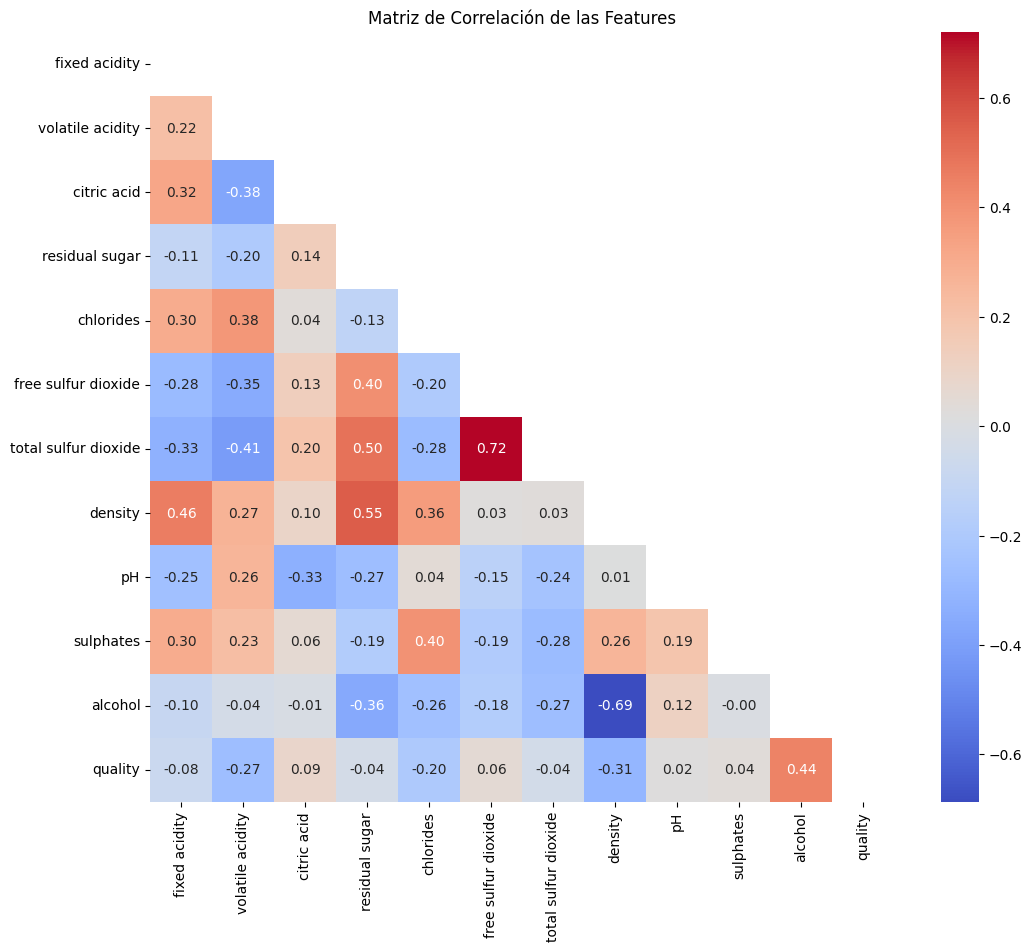

In [255]:
# Matriz de correlación de las variables fisicoquímicas
plt.figure(figsize=(12, 10))
# Excluimos la columna 'type' porque no es numérica
correlation_matrix = df.drop('type', axis=1).corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Matriz de Correlación de las Features')
plt.show()

### **(A COMPLETAR) Análisis del EDA**
*Observando las visualizaciones y estadísticas, respondan:*
- a. ¿Existen valores nulos en el dataset?
- b. ¿Qué variables parecen tener una mayor correlación (positiva o negativa) con la `quality`?
- c. ¿La distribución de la calidad es similar para vinos tintos y blancos? ¿Qué pueden decir de la distribución general de la calidad?

**Escriban sus respuestas aquí.**

a. ¿Existen valores nulos en el dataset?

In [256]:
nulos_por_columna = df.isnull().sum()

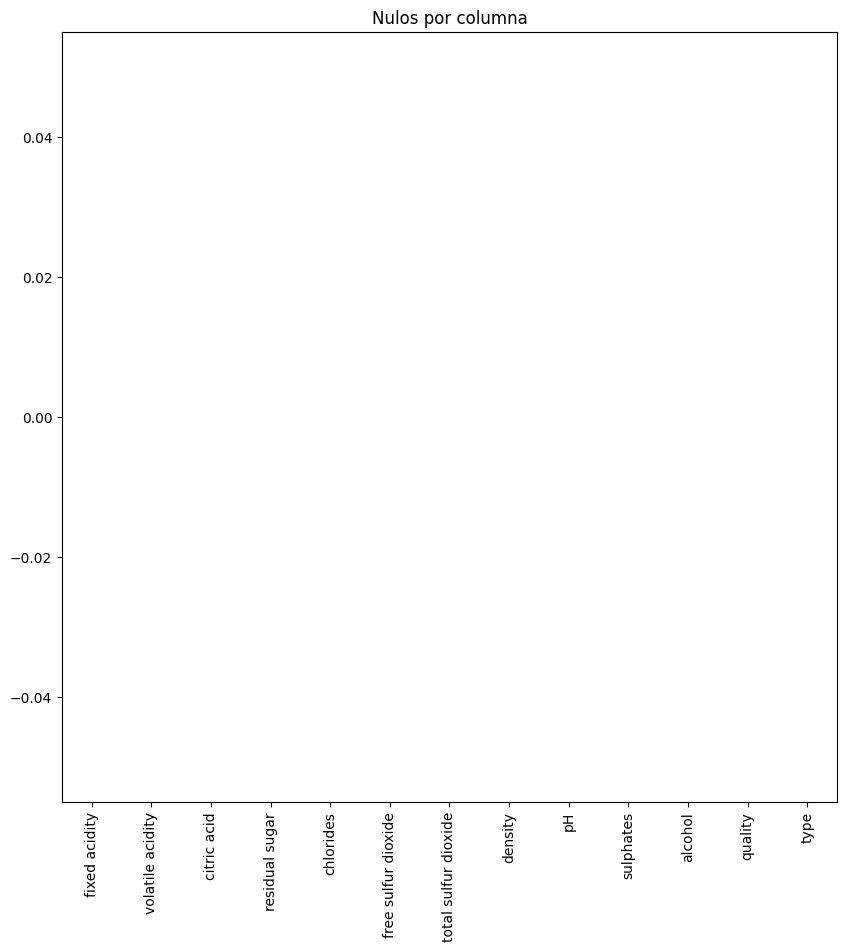

In [257]:
figure = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.title('Nulos por columna')
sns.barplot(nulos_por_columna)
plt.xticks(rotation=90)
plt.show()

<font color='green'>Respuesta: </font> En este conjunto de datos no hay precesencia de valores nulos explicitos en ninguna de las columnas.

b. ¿Qué variables parecen tener una mayor correlación (positiva o negativa) con la quality?

In [258]:
corr_matrix = df.corr(numeric_only=True)
corr_con_quality = corr_matrix['quality'].copy()
corr_con_quality = corr_con_quality.drop(index=['quality'])
corr_con_quality.sort_values(ascending=True, inplace=True, key=abs)

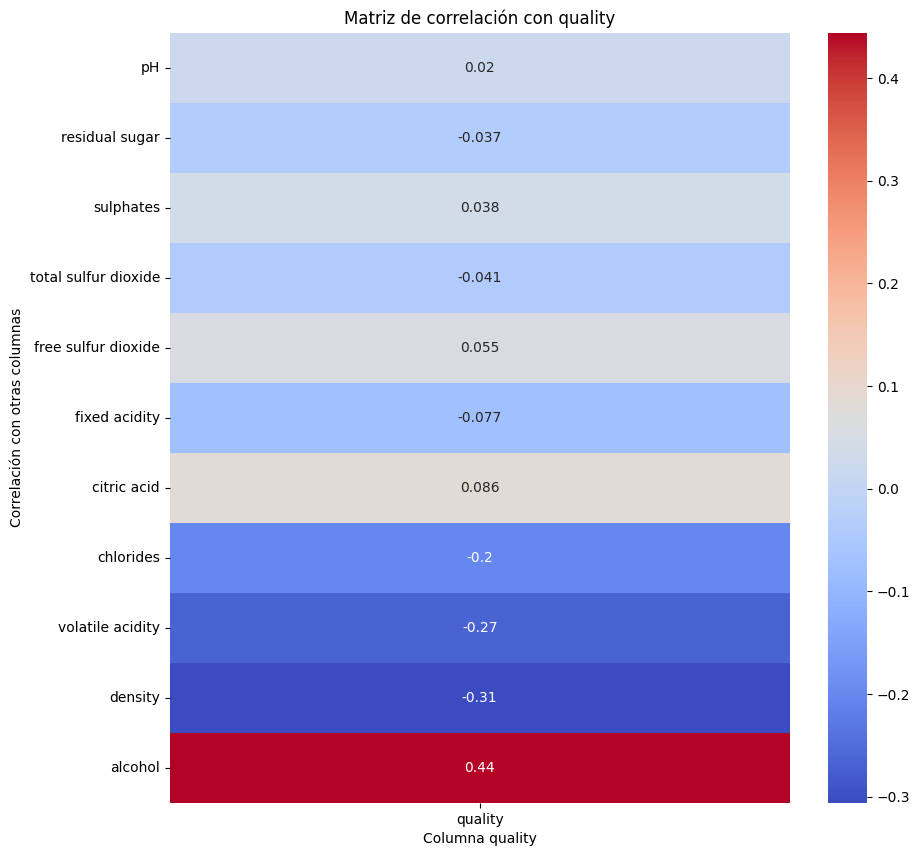

In [259]:
figure = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Matriz de correlación con quality')
sns.heatmap(corr_con_quality.to_frame(), cmap='coolwarm', annot=True)
plt.xlabel('Columna quality')
plt.ylabel('Correlación con otras columnas')
plt.show()

<font color='green'>Respuesta:</font> Las 3 columnas que tienen mayor correlación lineal con quality son:
1. `alcohol` con 44%
2. `density` con -31%
3. `volatile acidicity` con -27%

c. ¿La distribución de la calidad es similar para vinos tintos y blancos? ¿Qué pueden decir de la distribución general de la calidad?

In [260]:
frecuencia_vinos = df['type'].value_counts(normalize=True)
frecuencia_vinos = frecuencia_vinos.round(2)

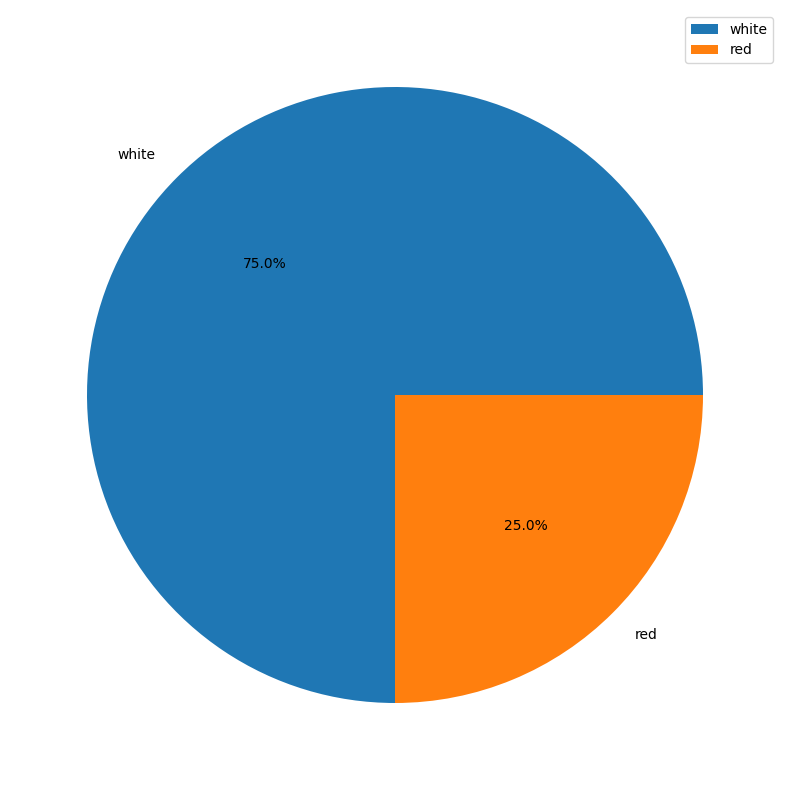

In [261]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.pie(frecuencia_vinos, labels= frecuencia_vinos.index, autopct="%1.1f%%")
plt.legend()
plt.show()

<font color='green'>Respuesta:</font> La distribución de vinos en general es mayor en vinos de tipo `white` con una freciencia relativa del 75% y red con una frecuencia relativa restante de 25%.

Respecto a cada una de la puntuaciónes en `quality` es proporcionalmente similar en ambos tipos de vinos, excepto en 6 puntos, donde en el tipo de vino `red` tiene menor frecuencia que 5 puntos, mientras que en el tipo de vino `white` es a la inversa.

<a name="clasificacion"></a>
## 4. Tarea 1: Clasificación (Predecir Tipo de Vino)
El objetivo aquí es construir un modelo que pueda identificar si un vino es tinto o blanco basándose en sus características fisicoquímicas.

In [370]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'DecisionTreeClassifierOpt', 'RandomForestClassifier', 'RandomForestClassifierOpt', 'XGBClassifier', 'XGBClassifierOpt']

In [371]:
columnas_rendimiento = ['train time', 'f1_weighted', 'accuracy']

In [372]:
modelos_rendimiento = pd.DataFrame(
    columns=columnas_rendimiento,
    index=models
)

modelos_rendimiento

,train time,f1_weighted,accuracy
LogisticRegression,NaN,NaN,NaN
DecisionTreeClassifier,NaN,NaN,NaN
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


<a name="prep_clasificacion"></a>
### 4.1. Preparación de Datos para Clasificación
Definiremos nuestras variables `X` (features) e `y` (target), y luego dividiremos los datos y los escalaremos.

In [265]:
# Definición de Features (X) y Target (y)
X_clf = df.drop('type', axis=1)
y_clf = df['type']

In [266]:
# División en Train y Test (estratificada para mantener la proporción de clases)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf
)

In [267]:
# Escalar las features es crucial para muchos modelos
scaler_clf = StandardScaler()

X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

In [268]:
print("Forma de X_train escalado:", X_train_clf_scaled.shape)
print("Forma de X_test escalado:", X_test_clf_scaled.shape)

Forma de X_train escalado: (4872, 12)
Forma de X_test escalado: (1625, 12)


<a name="modelos_base_clasificacion"></a>
### 4.2. Modelos Base de Clasificación
Comenzamos con modelos simples para tener una línea de base (baseline) de rendimiento.

Modelo base 1: Regresión Logística

In [269]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

In [270]:
log_reg_init_time = time()

log_reg.fit(X_train_clf_scaled, y_train_clf)

log_reg_finish_time = time()
log_reg_time = log_reg_finish_time - log_reg_init_time
modelos_rendimiento.loc['LogisticRegression', 'train time'] =  log_reg_time

In [271]:
y_pred_log = log_reg.predict(X_test_clf_scaled)

In [272]:
modelos_rendimiento.columns

Index(['train time', 'f1_weighted', 'accuracy'], dtype='object')

In [273]:
f1_score_log_reg = f1_score(y_true=y_test_clf, y_pred=y_pred_log, pos_label='white', average='weighted')
modelos_rendimiento.loc['LogisticRegression','f1_weighted'] = f1_score_log_reg
print('F1-score: ', f1_score_log_reg)

accuracy_score_log_reg = accuracy_score(y_true=y_test_clf, y_pred=y_pred_log)
modelos_rendimiento.loc['LogisticRegression', 'accuracy'] = accuracy_score_log_reg
print('Accuracy score: ', accuracy_score_log_reg)

print()
print(classification_report(y_test_clf, y_pred_log))

F1-score:  0.9913846153846154
Accuracy score:  0.9913846153846154

              precision    recall  f1-score   support

         red       0.98      0.98      0.98       400
       white       0.99      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Modelo base 2: Árbol de Decisión

In [274]:
tree_clf = DecisionTreeClassifier(random_state=42)

In [275]:
tree_init_time = time()

tree_clf.fit(X_train_clf_scaled, y_train_clf)

tree_finish_time = time()
tree_time = tree_finish_time - tree_init_time
modelos_rendimiento.loc['DecisionTreeClassifier', 'train time'] = tree_time
tree_time

0.0497739315032959

In [276]:
y_pred_tree = tree_clf.predict(X_test_clf_scaled)

In [277]:
tree_f1_score = f1_score(y_true=y_test_clf, y_pred=y_pred_tree, pos_label='white', average='weighted')
modelos_rendimiento.loc['DecisionTreeClassifier', 'f1_weighted'] = tree_f1_score
print('F1-score:', tree_f1_score)

tree_accuracy_score = accuracy_score(y_true=y_test_clf, y_pred=y_pred_tree)
modelos_rendimiento.loc['DecisionTreeClassifier', 'accuracy'] = tree_accuracy_score
print('Accuracy score:', tree_accuracy_score)

print()
print(classification_report(y_test_clf, y_pred_tree))

F1-score: 0.9853035539041592
Accuracy score: 0.9852307692307692

              precision    recall  f1-score   support

         red       0.96      0.98      0.97       400
       white       1.00      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.98      0.99      0.98      1625
weighted avg       0.99      0.99      0.99      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


<a name="completar_clasificacion"></a>
### 4.3. (A COMPLETAR) Modelos Avanzados y Optimización
Ahora es su turno. Deben entrenar un `RandomForestClassifier` y un `XGBClassifier`. Para ambos, utilicen `GridSearchCV` para encontrar los mejores hiperparámetros. Pueden utilizar las plantillas de las clases pasadas.

In [278]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [279]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [280]:
from time import time

#### RandomForestClassifier

In [281]:
rf = RandomForestClassifier(random_state=42)

In [282]:
rf_init_time = time()

rf.fit(X_train_clf_scaled, y_train_clf)

rf_final_time = time()
rf_train_time = rf_final_time - rf_init_time
modelos_rendimiento.loc['RandomForestClassifier', 'train time'] = rf_train_time
rf_train_time

0.578711748123169

In [283]:
rf_train_pred = rf.predict(X_train_clf_scaled)
rf_test_pred = rf.predict(X_test_clf_scaled)

In [284]:
print(modelos_rendimiento.index)
print()
print(modelos_rendimiento.columns)

Index(['LogisticRegression', 'DecisionTreeRegresor', 'DecisionTreeClassifier',
       'DecisionTreeClassifierOpt', 'RandomForestClassifier',
       'RandomForestClassifierOpt', 'XGBClassifier', 'XGBClassifierOpt'],
      dtype='object')

Index(['train time', 'f1_weighted', 'accuracy'], dtype='object')


In [285]:
rf_accuracy = accuracy_score(y_true=y_test_clf, y_pred=rf_test_pred)
modelos_rendimiento.loc['RandomForestClassifier', 'accuracy'] = rf_accuracy
print('accuracy score:', rf_accuracy)

rf_f1_score = f1_score(y_true=y_test_clf, y_pred=rf_test_pred, pos_label='white', average='weighted')
modelos_rendimiento.loc['RandomForestClassifier', 'f1_weighted'] = rf_f1_score
print('f1_score:', rf_f1_score)

print('-------------------------------')

train_class_report = classification_report(y_true=y_train_clf, y_pred=rf_train_pred)
print(train_class_report)

print('-------------------------------')

test_class_report = classification_report(y_true=y_test_clf, y_pred=rf_test_pred)
print(test_class_report)

accuracy score: 0.9950769230769231
f1_score: 0.9950769230769231
-------------------------------
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

-------------------------------
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       1.00      1.00      1.00      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### RandomForestClassifier optimizado

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [286]:
rf_grid_param = {
    # Número de árboles en el bosque
    "n_estimators": [100, 300, 500, 1000],

    # Profundidad máxima de los árboles
    "max_depth": [None, 5, 10, 20, 50],

    # Número mínimo de muestras para dividir un nodo
    "min_samples_split": [2, 5, 10],

    # Número mínimo de muestras en una hoja
    "min_samples_leaf": [1, 2, 4, 10],

    # Número de características a considerar en cada división
    "max_features": ["sqrt", "log2", None],

    # Criterio de calidad de la división
    "criterion": ["gini", "entropy", "log_loss"]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [287]:
rf_opt = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
        ),
    param_distributions=rf_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [288]:
rf_opt_init_time = time()

rf_opt.fit(X_train_clf_scaled, y_train_clf)

rf_opt_final_time = time()
rf_opt_train_time = rf_opt_final_time - rf_opt_init_time
modelos_rendimiento.loc['RandomForestClassifierOpt', 'train time'] = rf_opt_train_time
rf_opt_train_time

41.01144456863403

4. Predicciones utilizando la instancia

In [289]:
rf_train_pred = rf_opt.predict(X_train_clf_scaled)
rf_test_pred = rf_opt.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [290]:
print(modelos_rendimiento.index)
print()
print(modelos_rendimiento.columns)

Index(['LogisticRegression', 'DecisionTreeRegresor', 'DecisionTreeClassifier',
       'DecisionTreeClassifierOpt', 'RandomForestClassifier',
       'RandomForestClassifierOpt', 'XGBClassifier', 'XGBClassifierOpt'],
      dtype='object')

Index(['train time', 'f1_weighted', 'accuracy'], dtype='object')


In [291]:
rf_opt_accuracy = accuracy_score(y_true=y_test_clf, y_pred=rf_test_pred)
modelos_rendimiento.loc['RandomForestClassifierOpt', 'accuracy'] = rf_opt_accuracy
print('accuracy score:', rf_opt_accuracy)

rf_opt_f1_score = f1_score(y_true=y_test_clf, y_pred=rf_test_pred, pos_label='white', average='weighted')
modelos_rendimiento.loc['RandomForestClassifierOpt', 'f1_weighted'] = rf_opt_f1_score
print('f1_score:', rf_opt_f1_score)

print('-------------------------------')

train_class_report = classification_report(y_true=y_train_clf, y_pred=rf_train_pred)
print(train_class_report)

print('-------------------------------')

test_class_report = classification_report(y_true=y_test_clf, y_pred=rf_test_pred)
print(test_class_report)

accuracy score: 0.9950769230769231
f1_score: 0.9950769230769231
-------------------------------
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

-------------------------------
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       1.00      1.00      1.00      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### XGBClassifier

In [292]:
xgb_oh_enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [293]:
xgb_oh_enc.fit(y_train_clf.to_frame())

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [294]:
y_train_clf_xgb = xgb_oh_enc.transform(y_train_clf.to_frame())
y_test_clf_xgb = xgb_oh_enc.transform(y_test_clf.to_frame())

In [295]:
xgb_clf = XGBClassifier()

In [296]:
xgb_clf_init_time = time()

xgb_clf.fit(X_train_clf_scaled, y_train_clf_xgb)

xgb_clf_finish_time = time()
xgb_clf_time = xgb_clf_finish_time - xgb_clf_init_time
modelos_rendimiento.loc['XGBClassifier', 'train time'] = xgb_clf_time
modelos_rendimiento.loc['XGBClassifier', 'train time']

0.059458255767822266

In [297]:
y_pred_xgb_clf = xgb_clf.predict(X_test_clf_scaled)

In [298]:
xgb_clf_accuracy = accuracy_score(y_true=y_test_clf_xgb, y_pred=y_pred_xgb_clf)
modelos_rendimiento.loc['XGBClassifier', 'accuracy'] = xgb_clf_accuracy
print('Accuracy score:', xgb_clf_accuracy)

xgb_clf_f1 = f1_score(y_true=y_test_clf_xgb, y_pred=y_pred_xgb_clf, pos_label='white', average='weighted')
modelos_rendimiento.loc['XGBClassifier', 'f1_weighted'] = xgb_clf_f1
print('F1-score:', xgb_clf_f1)

print()
test_class_report = classification_report(y_true=y_test_clf_xgb, y_pred=y_pred_xgb_clf)
print(test_class_report)

Accuracy score: 0.9956923076923077
F1-score: 0.9956977138440604

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       400
         1.0       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      1.00      0.99      1625
weighted avg       1.00      1.00      1.00      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### XGBClassifier optimizado

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [299]:
xgb_grid_param = {
    # Número de árboles (boosting rounds)
    "n_estimators": [100, 300, 500, 1000],

    # Tasa de aprendizaje
    "learning_rate": [0.01, 0.05, 0.1, 0.2],

    # Profundidad máxima del árbol
    "max_depth": [3, 5, 7, 10],

    # Número mínimo de muestras en una hoja
    "min_child_weight": [1, 3, 5, 10],

    # Gamma: reducción mínima de pérdida para hacer un split
    "gamma": [0, 0.1, 0.5, 1]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [300]:
xgb_opt = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
        ),
    param_distributions=xgb_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [301]:
xgb_opt_init_time = time()

xgb_opt.fit(X_train_clf_scaled, y_train_clf_xgb)

xgb_opt_final_time = time()
xgb_opt_train_time = xgb_opt_final_time - xgb_opt_init_time
modelos_rendimiento.loc['XGBClassifierOpt', 'train time'] = xgb_opt_train_time
xgb_opt_train_time

4.010137557983398

4. Predicciones utilizando la instancia

In [302]:
xgb_opt_train_pred = xgb_opt.predict(X_train_clf_scaled)
xgb_opt_test_pred = xgb_opt.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [303]:
xgb_clf_opt_accuracy = accuracy_score(y_true=y_test_clf_xgb, y_pred=xgb_opt_test_pred)
modelos_rendimiento.loc['XGBClassifierOpt', 'accuracy'] = xgb_clf_opt_accuracy
print('Accuracy score:', xgb_clf_opt_accuracy)

xgb_opt_clf_f1 = f1_score(y_true=y_test_clf_xgb, y_pred=xgb_opt_test_pred, pos_label='white', average='weighted')
modelos_rendimiento.loc['XGBClassifierOpt', 'f1_weighted'] = xgb_opt_clf_f1
print('F1-score:', xgb_opt_clf_f1)

train_class_report = classification_report(y_true=y_train_clf_xgb, y_pred=xgb_opt_train_pred)
print(train_class_report)

test_class_report = classification_report(y_true=y_test_clf_xgb, y_pred=xgb_opt_test_pred)
print(test_class_report)

Accuracy score: 0.9969230769230769
F1-score: 0.996926938460043
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1199
         1.0       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       400
         1.0       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### DecisionTreeClassifier optimizado

1. Definiendo grilla de hiperparámetros para `DecisionTreeClassifier optimizado `

In [304]:
param_grid_dt = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

2. Instanciando `GridSearchCV` con una instancia de `DecisionTreeClassifier optimizado `

In [305]:
decision_tree_opt = GridSearchCV(
    estimator = DecisionTreeClassifier(
        random_state=42
    ),
    cv=3,
    param_grid=param_grid_dt,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

3. Entrenando la instancia de `GridSearchCV`

In [306]:
decision_tree_opt_init_time = time()

decision_tree_opt.fit(X_train_clf_scaled, y_train_clf)

decision_tree_opt_finish_time = time()
decision_tree_opt_time = decision_tree_opt_finish_time - decision_tree_opt_init_time
modelos_rendimiento.loc['DecisionTreeClassifierOpt', 'train time'] = decision_tree_opt_time
decision_tree_opt_time

29.158758878707886

4. Predicciones utilizando la instancia

In [307]:
decision_tree_opt_train_preds = decision_tree_opt.predict(X_train_clf_scaled)
decision_tree_opt_test_preds = decision_tree_opt.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [308]:
decision_tree_opt_accuracy = accuracy_score(y_true=y_test_clf, y_pred=decision_tree_opt_test_preds)
modelos_rendimiento.loc['DecisionTreeClassifierOpt', 'accuracy'] = decision_tree_opt_accuracy
print('Accuracy score:', decision_tree_opt_accuracy)

decision_tree_opt_f1 = f1_score(y_true=y_test_clf, y_pred=decision_tree_opt_test_preds, pos_label='white', average='weighted')
modelos_rendimiento.loc['DecisionTreeClassifierOpt', 'f1_weighted'] = decision_tree_opt_f1
print('F1-score:', decision_tree_opt_f1)

dt_train_report = classification_report(y_pred=decision_tree_opt_train_preds, y_true=y_train_clf)
print(dt_train_report)

dt_test_report = classification_report(y_pred=decision_tree_opt_test_preds, y_true=y_test_clf)
print(dt_test_report)

Accuracy score: 0.9901538461538462
F1-score: 0.9901455231754881
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

              precision    recall  f1-score   support

         red       0.98      0.98      0.98       400
       white       0.99      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### LogisticRegression optimizado

1. Definiendo grilla de hiperparámetros para `LogisticRegression optimizado `

In [309]:
param_grid_logreg = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "saga"],
    "max_iter": [100, 500, 1000],
    "class_weight": [None, "balanced"]
}

2. Instanciando `GridSearchCV` con una instancia de `LogisticRegression optimizado `

In [310]:
log_reg_opt = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42
        ),
    param_grid=param_grid_logreg,
    cv=3,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

3. Entrenando la instancia de `GridSearchCV`

In [311]:
log_reg_opt_init_time = time()

log_reg_opt.fit(X_train_clf_scaled, y_train_clf)

log_reg_opt_finish_time = time()
log_reg_opt_time = log_reg_opt_finish_time - log_reg_opt_init_time
modelos_rendimiento.loc['LogisticRegressionOpt', 'train time'] = log_reg_opt_time
log_reg_opt_time

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

41.262009382247925

4. Predicciones utilizando la instancia

In [312]:
log_reg_opt_train_preds = log_reg_opt.predict(X_train_clf_scaled)

In [313]:
log_reg_opt_test_preds = log_reg_opt.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [314]:
log_reg_opt_accuracy = accuracy_score(y_true=y_test_clf, y_pred=log_reg_opt_test_preds)
modelos_rendimiento.loc['LogisticRegressionOpt', 'accuracy'] = log_reg_opt_accuracy
print('Accuracy score:', log_reg_opt_accuracy)

log_reg_opt_f1 = f1_score(y_true=y_test_clf, y_pred=log_reg_opt_test_preds, pos_label='white', average='weighted')
modelos_rendimiento.loc['LogisticRegressionOpt', 'f1_weighted'] = log_reg_opt_f1
print('F1-score:', log_reg_opt_f1)

class_report_log_reg_opt_train = classification_report(y_true=y_train_clf, y_pred=log_reg_opt_train_preds)
print(class_report_log_reg_opt_train)

print('-------------------------')

class_report_log_reg_opt_test = classification_report(y_true=y_test_clf, y_pred=log_reg_opt_test_preds)
print(class_report_log_reg_opt_test)

Accuracy score: 0.9944615384615385
F1-score: 0.994463864918671
              precision    recall  f1-score   support

         red       0.99      0.99      0.99      1199
       white       1.00      1.00      1.00      3673

    accuracy                           0.99      4872
   macro avg       0.99      0.99      0.99      4872
weighted avg       0.99      0.99      0.99      4872

-------------------------
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


<a name="conclusion_clasificacion"></a>
### 4.4. (A COMPLETAR) Tabla de Resultados y Conclusión de Clasificación
Completen la siguiente tabla con los resultados obtenidos y escriban una conclusión clara.

In [315]:
modelos_rendimiento = modelos_rendimiento.round(2)
modelos_rendimiento

,train time,f1_weighted,accuracy
LogisticRegression,0.011626,0.991385,0.991385
DecisionTreeRegresor,NaN,NaN,NaN
DecisionTreeClassifier,0.049774,0.985304,0.985231
DecisionTreeClassifierOpt,29.158759,0.990146,0.990154
RandomForestClassifier,0.578712,0.995077,0.995077
RandomForestClassifierOpt,41.011445,0.995077,0.995077
XGBClassifier,0.059458,0.995698,0.995692
XGBClassifierOpt,4.010138,0.996927,0.996923
LogisticRegressionOpt,41.262009,0.994464,0.994462


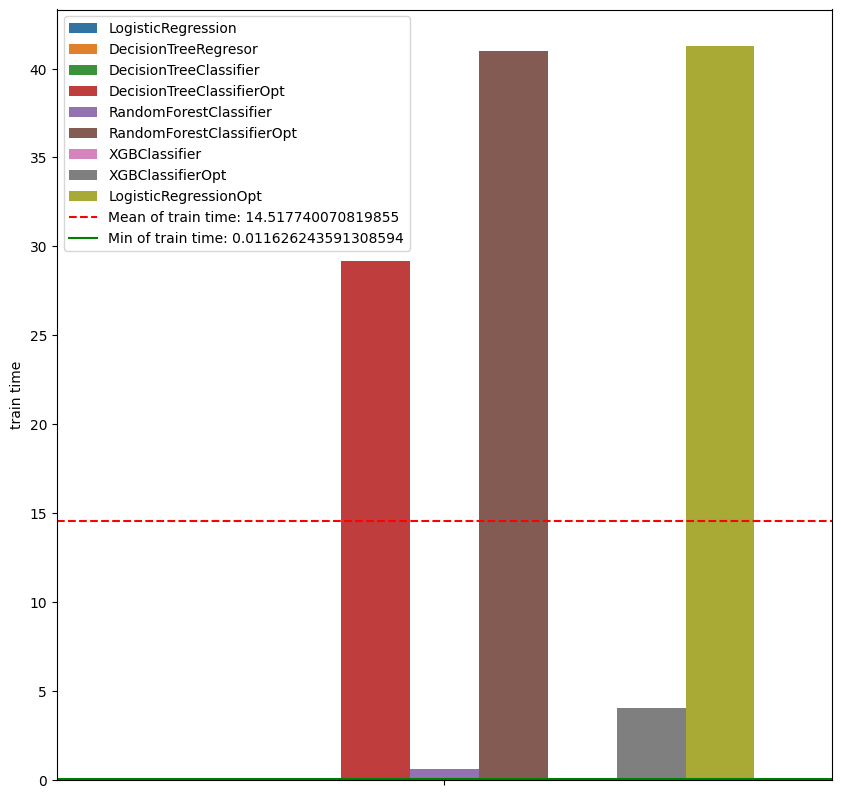

In [316]:
train_time_mean = modelos_rendimiento['train time'].mean()
train_time_min = modelos_rendimiento['train time'].min()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='train time', data=modelos_rendimiento, ax=ax, hue=modelos_rendimiento.index)
ax.axhline(train_time_mean, label=f'Mean of train time: {train_time_mean}', c='red', linestyle='--')
ax.axhline(train_time_min, label=f'Min of train time: {train_time_min}', c='green', linestyle='-')
ax.legend()

plt.show()

In [317]:
modelos_rendimiento.columns

Index(['train time', 'f1_weighted', 'accuracy'], dtype='object')

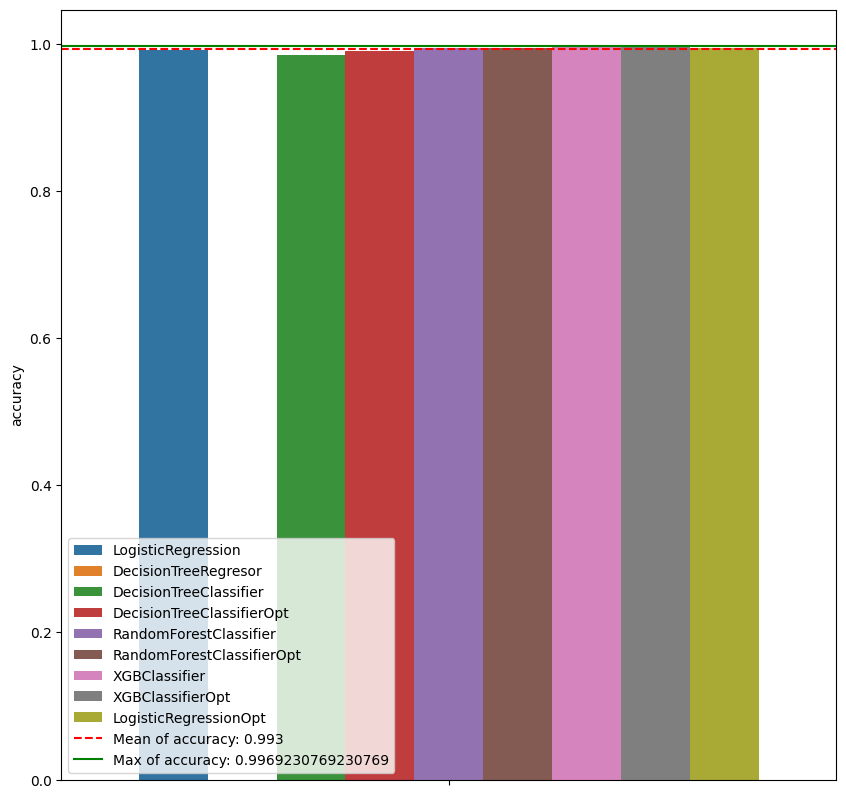

In [318]:
accuracy_mean = modelos_rendimiento['accuracy'].mean()
accuracy_max = modelos_rendimiento['accuracy'].max()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='accuracy', data=modelos_rendimiento, ax=ax, hue=modelos_rendimiento.index)
ax.axhline(accuracy_mean, label=f'Mean of accuracy: {accuracy_mean}', c='red', linestyle='--')
ax.axhline(accuracy_max, label=f'Max of accuracy: {accuracy_max}', c='green', linestyle='-')

ax.legend()
plt.show()

In [319]:
modelos_rendimiento.columns

Index(['train time', 'f1_weighted', 'accuracy'], dtype='object')

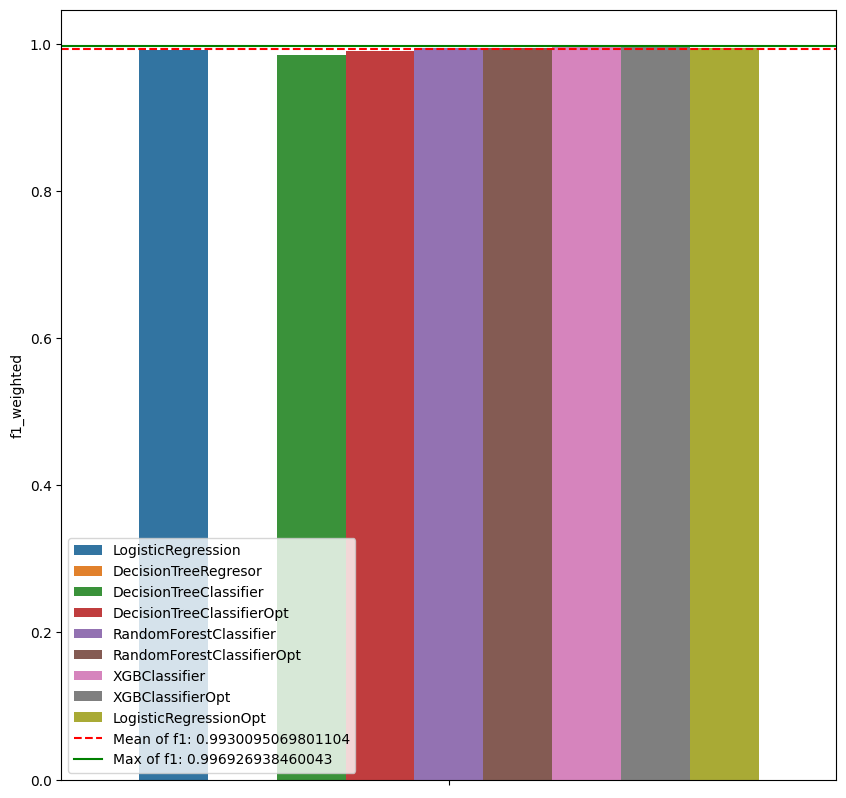

In [320]:
f1_mean = modelos_rendimiento['f1_weighted'].mean()
f1_max = modelos_rendimiento['f1_weighted'].max()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='f1_weighted', data=modelos_rendimiento, ax=ax, hue=modelos_rendimiento.index)
ax.axhline(accuracy_mean, label=f'Mean of f1: {f1_mean}', c='red', linestyle='--')
ax.axhline(accuracy_max, label=f'Max of f1: {f1_max}', c='green', linestyle='-')

ax.legend()
plt.show()

In [321]:
mask_modelos_rendimiento = (
    (modelos_rendimiento['f1_weighted'] >= modelos_rendimiento['f1_weighted'].quantile(0.90)) &
    (modelos_rendimiento['accuracy'] >= modelos_rendimiento['accuracy'].quantile(0.90)) &
    (modelos_rendimiento['train time'] < modelos_rendimiento['train time'].quantile(0.50))
)

modelos_rendimiento_filtrado = modelos_rendimiento[mask_modelos_rendimiento]

In [322]:
row_index = 'XGBClassifier'

# Aplicar estilo
modelos_rendimiento_filtrado.style.apply(highlight_best, axis=1, row_index=row_index)

,train time,f1_weighted,accuracy


Deberán completar la siguiente tabla:

| Modelo | Accuracy | F1-Score (weighted avg) | Mejores Hiperparámetros (GridSearch) |
| :--- | :--- | :--- | :--- |
| Regresión Logística |...| ...| N/A |
| Árbol de Decisión   |...| ...| N/A |
| Random Forest       | ...    | ...    | {'n_estimators': ..., 'max_depth': ...} |
| XGBoost             | ...    | ...    | {'n_estimators': ..., 'learning_rate': ...} |

---

### Conclusión de la Tarea de Clasificación

**Escriban su conclusión aquí.**
*Basándose en las métricas, ¿qué modelo es el mejor para esta tarea? ¿Por qué? Consideren no solo la performance (Accuracy/F1-score) sino también otros factores como el tiempo de entrenamiento o la interpretabilidad.*

<a name="regresion"></a>
## 5. Tarea 2: Regresión (Predecir Calidad del Vino)
Ahora, el objetivo es predecir la puntuación de `quality` del vino.

<a name="prep_regresion"></a>
### 5.1. Preparación de Datos para Regresión

In [323]:
# Definición de Features (X) y Target (y)
# Usaremos las mismas features, pero sin 'type' y el target ahora es 'quality'
X_reg = df.drop(['type', 'quality'], axis=1)
y_reg = df['quality']

In [324]:
# División en Train y Test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

In [325]:
# Escalamiento de datos
scaler_reg = StandardScaler()

X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

<a name="modelo_base_regresion"></a>
### 5.2. Modelo Base de Regresión

Modelo base 1: Regresión Lineal

In [326]:
lin_reg = LinearRegression()

In [327]:
lin_reg.fit(X_train_reg_scaled, y_train_reg)

LinearRegression()

In [328]:
y_pred_lin = lin_reg.predict(X_test_reg_scaled)

In [329]:
mae_lin = mean_absolute_error(y_test_reg, y_pred_lin)
r2_lin = r2_score(y_test_reg, y_pred_lin)

print(f"MAE Regresión Lineal: {mae_lin:.4f}")
print(f"R² Score Regresión Lineal: {r2_lin:.4f}")

MAE Regresión Lineal: 0.5703
R² Score Regresión Lineal: 0.2589


Modelo base 2: Árbol de Decisión para Regresión

In [330]:
tree_reg = DecisionTreeRegressor(max_depth = 3, random_state=42)

In [331]:
tree_reg.fit(X_train_reg_scaled, y_train_reg)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [332]:
y_pred_tree_reg = tree_reg.predict(X_test_reg_scaled)

In [333]:
mae_tree_reg = mean_absolute_error(y_test_reg, y_pred_tree_reg)
r2_tree_reg = r2_score(y_test_reg, y_pred_tree_reg)

print(f"MAE Árbol de Decisión: {mae_tree_reg:.4f}")
print(f"R² Score Árbol de Decisión: {r2_tree_reg:.4f}")

MAE Árbol de Decisión: 0.5961
R² Score Árbol de Decisión: 0.2444


Modelo base 3: RandomForest para Regresión

In [334]:
rf_reg = RandomForestRegressor(max_depth = 3, random_state=42)

In [335]:
rf_reg.fit(X_train_reg_scaled, y_train_reg)

RandomForestRegressor(max_depth=3, random_state=42)

In [336]:
y_pred_rf_reg = rf_reg.predict(X_test_reg_scaled)

In [337]:
mae_rf_reg = mean_absolute_error(y_test_reg, y_pred_rf_reg)
r2_rf_reg = r2_score(y_test_reg, y_pred_rf_reg)

print(f"MAE Random Forest: {mae_rf_reg:.4f}")
print(f"R² Score Random Forest: {r2_rf_reg:.4f}")

MAE Random Forest: 0.5799
R² Score Random Forest: 0.2659


<a name="completar_regresion"></a>
### 5.3. (A COMPLETAR) Modelos Avanzados y Optimización
Al igual que en la tarea de clasificación, deben implementar y optimizar los modelos `RandomForestRegressor` y `XGBRegressor`. Pueden utilizar las plantillas de las clases pasadas.

Convertimos el problema a uno de clasificación

In [338]:
X_reg_clf = df.drop(columns=['quality']).copy()
y_reg_clf = df['quality']

In [339]:
bad_quality_mask = y_reg_clf <= 5
good_quality_mask = y_reg_clf > 5

y_reg_clf[bad_quality_mask] = 'bad_quality'
y_reg_clf[good_quality_mask] = 'good_quality'

y_reg_clf.value_counts()

/tmp/ipython-input-2158738297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_reg_clf[bad_quality_mask] = 'bad_quality'
/tmp/ipython-input-2158738297.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'bad_quality' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_reg_clf[bad_quality_mask] = 'bad_quality'


,count
quality,
good_quality,4113
bad_quality,2384


DecisionTreeClassifier

In [340]:
param_grid_dt = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

In [341]:
d_tree_quality = GridSearchCV(
    estimator = DecisionTreeClassifier(
        random_state=42
    ),
    cv=3,
    param_grid=param_grid_dt,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

In [342]:
X_reg_clf.drop(columns=['type'], inplace=True)

In [343]:
X_quality_train, X_quality_test, y_quality_train, y_quality_test = train_test_split(X_reg_clf, y_reg_clf, random_state=42, stratify=y_reg_clf)

In [344]:
modelos_rendimiento

,train time,f1_weighted,accuracy
LogisticRegression,0.011626,0.991385,0.991385
DecisionTreeRegresor,NaN,NaN,NaN
DecisionTreeClassifier,0.049774,0.985304,0.985231
DecisionTreeClassifierOpt,29.158759,0.990146,0.990154
RandomForestClassifier,0.578712,0.995077,0.995077
RandomForestClassifierOpt,41.011445,0.995077,0.995077
XGBClassifier,0.059458,0.995698,0.995692
XGBClassifierOpt,4.010138,0.996927,0.996923
LogisticRegressionOpt,41.262009,0.994464,0.994462


In [345]:
d_tree_quality_init_time = time()
d_tree_quality.fit(X_quality_train, y_quality_train)
d_tree_quality_final_time = time()
d_tree_quality_time = d_tree_quality_final_time - d_tree_quality_init_time
modelos_rendimiento.loc['DecisionTreeClassifierQuality', 'train time'] = d_tree_quality_time

In [346]:
d_tree_test_pred = d_tree_quality.predict(X_quality_test)

In [347]:
d_tree_quality_f1_score = f1_score(y_true = y_quality_test, y_pred = d_tree_test_pred, average='weighted')
modelos_rendimiento.loc['DecisionTreeClassifierQuality', 'f1_weighted'] = d_tree_quality_f1_score
print('f1_score:', d_tree_quality_f1_score)
print()

d_tree_quality_accuracy_score = accuracy_score(y_true = y_quality_test, y_pred = d_tree_test_pred)
modelos_rendimiento.loc['DecisionTreeClassifierQuality', 'accuracy'] = d_tree_quality_accuracy_score
print('Accuracy score:', d_tree_quality_accuracy_score)
print()

d_tree_quality_class_report = classification_report(y_true = y_quality_test, y_pred = d_tree_test_pred)
print(d_tree_quality_class_report)

f1_score: 0.750003829577762

Accuracy score: 0.7483076923076923

              precision    recall  f1-score   support

 bad_quality       0.65      0.69      0.67       596
good_quality       0.81      0.78      0.80      1029

    accuracy                           0.75      1625
   macro avg       0.73      0.74      0.73      1625
weighted avg       0.75      0.75      0.75      1625



LogisticRegression

In [348]:
sc_x_quality = StandardScaler()
sc_x_quality.fit(X_quality_train)

X_quality_train_scaled = sc_x_quality.transform(X_quality_train)
X_quality_test_scaled = sc_x_quality.transform(X_quality_test)

In [349]:
param_grid_logreg = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "saga"],
    "max_iter": [100, 500, 1000],
    "class_weight": [None, "balanced"]
}

In [350]:
log_reg_opt = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42
        ),
    param_grid=param_grid_logreg,
    cv=3,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

In [351]:
log_reg_opt_init_time = time()

log_reg_opt.fit(X_quality_train_scaled, y_quality_train)

log_reg_opt_finish_time = time()
log_reg_opt_time = log_reg_opt_finish_time - log_reg_opt_init_time
modelos_rendimiento.loc['LogisticRegressionQualityOpt', 'train time'] = log_reg_opt_time
log_reg_opt_time

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
630 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_sol

12.920551538467407

In [352]:
log_reg_quality_opt_train_preds = log_reg_opt.predict(X_quality_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [353]:
log_reg_quality_opt_test_preds = log_reg_opt.predict(X_quality_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [354]:
log_reg_quality_opt_accuracy = accuracy_score(y_true=y_quality_test, y_pred=log_reg_quality_opt_test_preds)
modelos_rendimiento.loc['LogisticRegressionQualityOpt', 'accuracy'] = log_reg_opt_accuracy
print('Accuracy score:', log_reg_quality_opt_accuracy)

log_reg_quality_opt_f1 = f1_score(y_true=y_test_clf, y_pred=log_reg_opt_test_preds, pos_label='white', average='weighted')
modelos_rendimiento.loc['LogisticRegressionQualityOpt', 'f1_weighted'] = log_reg_quality_opt_f1
print('F1-score:', log_reg_quality_opt_f1)

class_report_log_reg_opt_test = classification_report(y_true=y_quality_test, y_pred=log_reg_quality_opt_test_preds)
print(class_report_log_reg_opt_test)

Accuracy score: 0.4104615384615385
F1-score: 0.994463864918671
              precision    recall  f1-score   support

 bad_quality       0.37      0.87      0.52       596
good_quality       0.66      0.14      0.24      1029

    accuracy                           0.41      1625
   macro avg       0.51      0.51      0.38      1625
weighted avg       0.55      0.41      0.34      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


RandomForestClassifier Optimizado sobre columna Quality

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [355]:
rf_grid_param = {
    # Número de árboles en el bosque
    "n_estimators": [100, 300, 500, 1000],

    # Profundidad máxima de los árboles
    "max_depth": [None, 5, 10, 20, 50],

    # Número mínimo de muestras para dividir un nodo
    "min_samples_split": [2, 5, 10],

    # Número mínimo de muestras en una hoja
    "min_samples_leaf": [1, 2, 4, 10],

    # Número de características a considerar en cada división
    "max_features": ["sqrt", "log2", None],

    # Criterio de calidad de la división
    "criterion": ["gini", "entropy", "log_loss"]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [356]:
rf_opt = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
        ),
    param_distributions=rf_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [357]:
rf_opt_init_time = time()

rf_opt.fit(X_quality_train_scaled, y_quality_train)

rf_opt_final_time = time()
rf_opt_train_time = rf_opt_final_time - rf_opt_init_time
modelos_rendimiento.loc['RandomForestClassifierQualityOpt', 'train time'] = rf_opt_train_time
rf_opt_train_time

111.815021276474

4. Predicciones utilizando la instancia

In [358]:
rf_train_pred = rf_opt.predict(X_quality_train_scaled)
rf_test_pred = rf_opt.predict(X_quality_test_scaled)

5. Evaluación utilizando la instancia

In [359]:
rf_opt_accuracy = accuracy_score(y_true=y_quality_test, y_pred=rf_test_pred)
modelos_rendimiento.loc['RandomForestClassifierQualityOpt', 'accuracy'] = rf_opt_accuracy
print('accuracy score:', rf_opt_accuracy)

rf_opt_f1_score = f1_score(y_true=y_quality_test, y_pred=rf_test_pred, pos_label='white', average='weighted')
modelos_rendimiento.loc['RandomForestClassifierQualityOpt', 'f1_weighted'] = rf_opt_f1_score
print('f1_score:', rf_opt_f1_score)

print('-------------------------------')

train_class_report = classification_report(y_true=y_quality_train, y_pred=rf_train_pred)
print(train_class_report)

print('-------------------------------')

test_class_report = classification_report(y_true=y_quality_test, y_pred=rf_test_pred)
print(test_class_report)

accuracy score: 0.8363076923076923
f1_score: 0.8346655579189866
-------------------------------
              precision    recall  f1-score   support

 bad_quality       1.00      1.00      1.00      1788
good_quality       1.00      1.00      1.00      3084

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

-------------------------------
              precision    recall  f1-score   support

 bad_quality       0.80      0.73      0.77       596
good_quality       0.85      0.90      0.87      1029

    accuracy                           0.84      1625
   macro avg       0.83      0.81      0.82      1625
weighted avg       0.83      0.84      0.83      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


#### XGBClassifier optimizado para columna `quality`

In [360]:
xgb_oh_enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [361]:
xgb_oh_enc.fit(y_quality_train.to_frame())

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [362]:
y_quality_train_clf_xgb = xgb_oh_enc.transform(y_quality_train.to_frame())
y_quality_test_clf_xgb = xgb_oh_enc.transform(y_quality_test.to_frame())

In [363]:
xgb_clf = XGBClassifier()

1. Definiendo grilla de hiperparámetros para `XGBClassifier`

In [364]:
xgb_grid_param = {
    # Número de árboles (boosting rounds)
    "n_estimators": [100, 300, 500, 1000],

    # Tasa de aprendizaje
    "learning_rate": [0.01, 0.05, 0.1, 0.2],

    # Profundidad máxima del árbol
    "max_depth": [3, 5, 7, 10],

    # Número mínimo de muestras en una hoja
    "min_child_weight": [1, 3, 5, 10],

    # Gamma: reducción mínima de pérdida para hacer un split
    "gamma": [0, 0.1, 0.5, 1]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [365]:
xgb_opt = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
        ),
    param_distributions=xgb_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [366]:
xgb_opt_init_time = time()

xgb_opt.fit(X_quality_train_scaled, y_quality_train_clf_xgb)

xgb_opt_final_time = time()
xgb_opt_train_time = xgb_opt_final_time - xgb_opt_init_time
modelos_rendimiento.loc['XGBClassifierQualityOpt', 'train time'] = xgb_opt_train_time
xgb_opt_train_time

12.91831111907959

4. Predicciones utilizando la instancia

In [367]:
xgb_opt_train_pred = xgb_opt.predict(X_quality_train_scaled)
xgb_opt_test_pred = xgb_opt.predict(X_quality_test_scaled)

5. Evaluación utilizando la instancia

In [368]:
xgb_clf_opt_accuracy = accuracy_score(y_true=y_quality_test_clf_xgb, y_pred=xgb_opt_test_pred)
modelos_rendimiento.loc['XGBClassifierQualityOpt', 'accuracy'] = xgb_clf_opt_accuracy
print('Accuracy score:', xgb_clf_opt_accuracy)

xgb_opt_clf_f1 = f1_score(y_true=y_quality_test_clf_xgb, y_pred=xgb_opt_test_pred, pos_label='white', average='weighted')
modelos_rendimiento.loc['XGBClassifierQualityOpt', 'f1_weighted'] = xgb_opt_clf_f1
print('F1-score:', xgb_opt_clf_f1)

train_class_report = classification_report(y_true=y_quality_train_clf_xgb, y_pred=xgb_opt_train_pred)
print(train_class_report)

test_class_report = classification_report(y_true=y_quality_test_clf_xgb, y_pred=xgb_opt_test_pred)
print(test_class_report)

Accuracy score: 0.8276923076923077
F1-score: 0.8263434447133209
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1788
         1.0       0.98      0.99      0.99      3084

    accuracy                           0.98      4872
   macro avg       0.98      0.98      0.98      4872
weighted avg       0.98      0.98      0.98      4872

              precision    recall  f1-score   support

         0.0       0.78      0.73      0.76       596
         1.0       0.85      0.88      0.87      1029

    accuracy                           0.83      1625
   macro avg       0.82      0.81      0.81      1625
weighted avg       0.83      0.83      0.83      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [369]:
modelos_rendimiento

,train time,f1_weighted,accuracy
LogisticRegression,0.011626,0.991385,0.991385
DecisionTreeRegresor,NaN,NaN,NaN
DecisionTreeClassifier,0.049774,0.985304,0.985231
DecisionTreeClassifierOpt,29.158759,0.990146,0.990154
RandomForestClassifier,0.578712,0.995077,0.995077
RandomForestClassifierOpt,41.011445,0.995077,0.995077
XGBClassifier,0.059458,0.995698,0.995692
XGBClassifierOpt,4.010138,0.996927,0.996923
LogisticRegressionOpt,41.262009,0.994464,0.994462
DecisionTreeClassifierQuality,35.576876,0.750004,0.748308


Deberán completar la siguiente tabla:

| Modelo | MAE (Mean Absolute Error) | R² Score | Mejores Hiperparámetros (GridSearch) |
| :--- | :--- | :--- | :--- |
| Regresión Lineal | ...| ...| N/A |
| RandomForest Regressor| ...    | ...    | {...} |
| XGBoost Regressor     | ...    | ...    | {...} |

---

### Gráfico de Dispersión: Valores Reales vs. Predichos
*Generen aquí un scatter plot con los valores de `y_test_reg` en el eje X y las predicciones de su **mejor modelo** en el eje Y. Añadan una línea diagonal de referencia para visualizar qué tan buenas son las predicciones.*

### Conclusión de la Tarea de Regresión

**Escriban su conclusión aquí.**
*¿Qué modelo tuvo el mejor rendimiento? ¿Qué significan los valores de MAE y R² que obtuvieron? ¿La predicción de la calidad es una tarea fácil o difícil para estos modelos? Justifiquen su respuesta basándose en las métricas y el gráfico.*

<a name="final"></a>
## 6. (A COMPLETAR) Conclusiones Finales del Proyecto

En esta sección final, deben resumir los hallazgos de todo el proyecto.
* ¿Qué tarea fue más "fácil" para los modelos: clasificar el tipo de vino o predecir su calidad? ¿Por qué creen que fue así?
* ¿Qué importancia tuvo el preprocesamiento (escalado de datos)?
* ¿Valió la pena utilizar `GridSearchCV`? ¿Mejoró significativamente el rendimiento de los modelos base?
* Si tuvieran que presentarle una solución a la bodega, ¿qué modelos recomendarían para cada tarea y por qué?